# Goal
The goal of this project is to utilize existing open source AI model, specifically DeBERTA Base v3 and fine-tune it to perform down stream task of 
PII masking.





In [7]:
# add more dependencies here
!pip install pandas torch transformers tqdm protobuf tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.6/982.6 kB 1.1 MB/s eta 0:00:00a 0:00:01m


In [1]:
import json
import pandas as pd

# Read the JSONL file
data = []
with open('data/english_pii_43k.jsonl', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Convert to DataFrame for easier viewing
df = pd.DataFrame(data)

# Display first few examples
print("First 2 examples from the dataset:")
print("\nExample 1:")
print("Original text:", df.iloc[0]['unmasked_text'])
print("Masked text:", df.iloc[0]['masked_text'])
print("Privacy masks:", df.iloc[0]['privacy_mask'])

print("\nExample 2:")
print("Original text:", df.iloc[1]['unmasked_text'])
print("Masked text:", df.iloc[1]['masked_text'])
print("Privacy masks:", df.iloc[1]['privacy_mask'])


First 2 examples from the dataset:

Example 1:
Original text: A student's assessment was found on device bearing IMEI: 06-184755-866851-3. The document falls under the various topics discussed in our Optimization curriculum. Can you please collect it?
Masked text: A student's assessment was found on device bearing IMEI: [PHONEIMEI_1]. The document falls under the various topics discussed in our [JOBAREA_1] curriculum. Can you please collect it?
Privacy masks: {'[PHONEIMEI_1]': '06-184755-866851-3', '[JOBAREA_1]': 'Optimization'}

Example 2:
Original text: Dear Omer, as per our records, your license 78B5R2MVFAHJ48500 is still registered in our records for access to the educational tools. Please feedback on it's operability.
Masked text: Dear [FIRSTNAME_1], as per our records, your license [VEHICLEVIN_1] is still registered in our records for access to the educational tools. Please feedback on it's operability.
Privacy masks: {'[FIRSTNAME_1]': 'Omer', '[VEHICLEVIN_1]': '78B5R2MVFAHJ48500

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DebertaTokenizer, DebertaForTokenClassification
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW
import json
import numpy as np
from tqdm import tqdm
import os
from datetime import datetime
import glob

# Use full dataset instead of subset
class PIIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):  # Increased max_len
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Create label mapping
        unique_labels = set([label.split('-')[1] if '-' in label else label
                           for sequence in labels
                           for label in sequence])
        self.label2id = {label: idx for idx, label in enumerate(unique_labels)}
        self.id2label = {idx: label for label, idx in self.label2id.items()}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        # Convert labels to ids
        label_ids = [self.label2id.get(label.split('-')[1], 0) if '-' in label
                    else self.label2id.get(label, 0) for label in labels]

        # Tokenize and align labels
        encoding = self.tokenizer(' '.join(text),
                                padding='max_length',
                                truncation=True,
                                max_length=self.max_len,
                                return_tensors='pt')

        # Adjust labels to match tokenized input
        aligned_labels = [-100] * self.max_len
        aligned_labels[1:min(len(label_ids)+1, self.max_len)] = label_ids[:self.max_len-1]

        return {
            'input_ids': encoding['input_ids'][0],
            'attention_mask': encoding['attention_mask'][0],
            'labels': torch.tensor(aligned_labels)
        }

# Grab the tokenizer for deberta-base
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

# Split data into train/val sets
train_val_split = 0.9
train_size = int(len(df) * train_val_split)
indices = torch.randperm(len(df)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]

train_dataset = PIIDataset(train_df['tokenised_text'].values,
                          train_df['bio_labels'].values,
                          tokenizer)
val_dataset = PIIDataset(val_df['tokenised_text'].values,
                        val_df['bio_labels'].values,
                        tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
model = DebertaForTokenClassification.from_pretrained('microsoft/deberta-base',
                                                     num_labels=len(train_dataset.label2id))

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Learning rate scheduler
num_epochs = 5
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps * 0.1,  # 10% of total steps for warmup
    num_training_steps=total_steps
)

# Load checkpoint if exists
def load_checkpoint():
    checkpoints = glob.glob('checkpoints/checkpoint_*.pt')
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        checkpoint = torch.load(latest_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['batch_idx'], checkpoint['best_val_loss']
    return 0, 0, float('inf')

# Create checkpoints directory
os.makedirs('checkpoints', exist_ok=True)

# Training loop with validation
start_epoch, start_batch, best_val_loss = load_checkpoint()
early_stopping_patience = 3
no_improvement = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')

    for batch_idx, batch in enumerate(progress_bar):
        if epoch == start_epoch and batch_idx < start_batch:
            continue

        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask,
                       labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'loss': loss.item()})

        # Save checkpoint every 1000 batches
        if batch_idx % 1000 == 0:
            checkpoint = {
                'epoch': epoch,
                'batch_idx': batch_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }
            torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{epoch}_batch_{batch_idx}.pt')

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels)

            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch+1} - Validation loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
        model_save_path = f'models/pii_masking_model_best'
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stopping triggered")
            break

print("Training completed!")

# Save final model
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
final_model_path = f'models/pii_masking_model_final_{current_time}'
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)
print(f"Final model saved to {final_model_path}")


In [12]:

def save_checkpoint(model, optimizer, epoch, batch_idx, total_loss, checkpoint_dir='checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    checkpoint = {
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'total_loss': total_loss
    }

    temp_path = os.path.join(checkpoint_dir, 'temp_checkpoint.pt')
    final_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}_batch_{batch_idx}.pt')

    torch.save(checkpoint, temp_path)
    os.replace(temp_path, final_path)
    return final_path

def load_latest_checkpoint(checkpoint_dir='checkpoints'):
    if not os.path.exists(checkpoint_dir):
        return None

    checkpoints = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_*.pt'))
    if not checkpoints:
        return None

    latest_checkpoint = max(checkpoints, key=os.path.getctime)
    return torch.load(latest_checkpoint)

def evaluate_model(test_text, model, tokenizer, device, train_dataset):
    # Tokenize the test text
    test_tokens = tokenizer(test_text,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=512)

    test_tokens = {k: v.to(device) for k, v in test_tokens.items()}
    model.eval()

    # Get predictions
    with torch.no_grad():
        outputs = model(**test_tokens)
        predictions = torch.argmax(outputs.logits, dim=2)

    # Convert predictions to labels
    tokens = tokenizer.convert_ids_to_tokens(test_tokens['input_ids'][0])
    pred_labels = [list(train_dataset.label2id.keys())[p] for p in predictions[0]]

    current_entity = []
    current_label = None
    entities_to_mask = []
    current_start = None

    for i, (token, label) in enumerate(zip(tokens, pred_labels)):
        # Skip special tokens
        if token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue

        clean_token = token.replace("##", "")
        if clean_token.startswith("Ġ"):
            clean_token = clean_token[1:]

        if label.startswith("B-"):
            if current_entity:
                entities_to_mask.append((current_start, "".join(current_entity), current_label))
            current_entity = [clean_token]
            current_label = label.split("-")[1]
            current_start = test_text.lower().find(clean_token.lower())
        elif label.startswith("I-") and current_entity:
            current_entity.append(clean_token)
        else:
            if current_entity:
                entities_to_mask.append((current_start, "".join(current_entity), current_label))
                current_entity = []
                current_label = None
                current_start = None

    if current_entity:
        entities_to_mask.append((current_start, "".join(current_entity), current_label))

    # Sort entities by start position in reverse order
    entities_to_mask.sort(key=lambda x: x[0], reverse=True)

    # Create masked version of text
    masked_text = test_text
    mask_count = {}

    # Replace entities with masks
    for start_pos, entity_text, label in entities_to_mask:
        if start_pos != -1:
            if label not in mask_count:
                mask_count[label] = 1

            replacement = f"[{label}_{mask_count[label]}]"
            end_pos = start_pos + len(entity_text)
            masked_text = masked_text[:start_pos] + replacement + masked_text[end_pos:]
            mask_count[label] += 1

    return masked_text, tokens, pred_labels

# Example text for testing
test_text = "Hi, my name is Seng Horn Rith and my phone number is 0412345678. I don't like apples."

# Load latest checkpoint if exists
checkpoint = load_latest_checkpoint()
start_epoch = 0
start_batch = 0
if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    start_batch = checkpoint['batch_idx'] + 1
    print(f"Resuming training from epoch {start_epoch}, batch {start_batch}")

# Training loop with checkpointing
try:
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                          desc=f'Epoch {epoch+1}', initial=start_batch)

        for batch_idx, batch in progress_bar:
            if epoch == start_epoch and batch_idx < start_batch:
                continue

            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels)

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({'loss': loss.item()})

            # Save checkpoint every 50 batches
            if batch_idx % 50 == 0:
                checkpoint_path = save_checkpoint(model, optimizer, epoch, batch_idx, total_loss)
                print(f"\nCheckpoint saved: {checkpoint_path}")

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1} - Average loss: {avg_loss:.4f}')

        # Evaluate model after each epoch
        masked_text, tokens, pred_labels = evaluate_model(test_text, model, tokenizer, device, train_dataset)
        print("\nEvaluation after epoch:")
        print("Masked text:", masked_text)

        # Save checkpoint at end of each epoch
        checkpoint_path = save_checkpoint(model, optimizer, epoch, len(train_loader)-1, total_loss)
        print(f"\nEpoch checkpoint saved: {checkpoint_path}")

        # Reset start_batch for next epoch
        start_batch = 0

except KeyboardInterrupt:
    print("\nTraining interrupted! Saving checkpoint...")
    checkpoint_path = save_checkpoint(model, optimizer, epoch, batch_idx, total_loss)
    print(f"Checkpoint saved: {checkpoint_path}")
    print("You can resume training later from this checkpoint.")

except Exception as e:
    print(f"\nAn error occurred: {str(e)}")
    print("Saving emergency checkpoint...")
    checkpoint_path = save_checkpoint(model, optimizer, epoch, batch_idx, total_loss)
    print(f"Emergency checkpoint saved: {checkpoint_path}")
    raise e

print("Training completed!")

# Save final model safely
if not os.path.exists('models'):
    os.makedirs('models')

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
temp_model_path = f'models/temp_model_{current_time}'
final_model_path = f'models/pii_masking_model_{current_time}'

# Save to temporary location first
model.save_pretrained(temp_model_path)
tokenizer.save_pretrained(temp_model_path)

os.rename(temp_model_path, final_model_path)
print(f"Final model saved to {final_model_path}")

print("\nFinal evaluation:")
masked_text, tokens, pred_labels = evaluate_model(test_text, model, tokenizer, device, train_dataset)
print("Original text:", test_text)
print("\nTokens and their predicted labels:")
for token, label in zip(tokens, pred_labels):
    if label != "O" and token not in ["[CLS]", "[SEP]", "[PAD]"]:
        print(f"{token}: {label}")
print("\nMasked text:")
print(masked_text)


/var/folders/vh/8p_cpv610qv6r4jb9gpy5j6c0000gp/T/ipykernel_3027/3503507015.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(latest_checkpoint)


Resuming training from epoch 1, batch 1001


Epoch 2:  84%|████████▍ | 2052/2447 [04:19<39:24,  5.99s/it, loss=11.5] 


Checkpoint saved: checkpoints/checkpoint_epoch_1_batch_1050.pt


Epoch 2:  84%|████████▍ | 2061/2447 [05:10<01:53,  3.41it/s, loss=11.5]



Training interrupted! Saving checkpoint...
Checkpoint saved: checkpoints/checkpoint_epoch_1_batch_1060.pt
You can resume training later from this checkpoint.
Training completed!
Final model saved to models/pii_masking_model_20241205_164933

Final evaluation:
Original text: Hi, my name is John Smith and my phone number is 555-123-4567. I work in Data Science department.

Tokens and their predicted labels:
Hi: PHONEIMEI
,: PHONEIMEI
Ġmy: PHONEIMEI
Ġname: PHONEIMEI
Ġis: PHONEIMEI
ĠJohn: AGE
ĠSmith: IBAN
Ġand: PHONEIMEI
Ġmy: PHONEIMEI
Ġphone: PHONEIMEI
Ġnumber: PHONEIMEI
Ġis: PHONEIMEI
Ġ555: USERAGENT
-: USERAGENT
123: USERAGENT
-: USERAGENT
45: PHONEIMEI
67: PHONEIMEI
.: PHONEIMEI
ĠI: PHONEIMEI
Ġwork: PHONEIMEI
Ġin: MAC
ĠData: PHONEIMEI
ĠScience: PHONEIMEI
Ġdepartment: PHONEIMEI
.: PHONEIMEI

Masked text:
Hi, my name is John Smith and my phone number is 555-123-4567. I work in Data Science department.


In [16]:
# Load the saved model
checkpoint = torch.load("pii_masking_model_final.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

import numpy as np

def calculate_metrics(predictions, true_labels, label2id):
    """
    Calculate precision, recall, and F1 score for each label type
    """
    metrics = {}
    id2label = {v: k for k, v in label2id.items()}

    for label_id in range(len(label2id)):
        label_name = id2label[label_id]
        if label_name == 'O':  # Skip non-entity label
            continue

        true_positives = ((predictions == label_id) & (true_labels == label_id)).sum().item()
        false_positives = ((predictions == label_id) & (true_labels != label_id)).sum().item()
        false_negatives = ((predictions != label_id) & (true_labels == label_id)).sum().item()

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[label_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives
        }

    return metrics

# Evaluate on validation set with larger batch size
model.eval()
all_predictions = []
all_labels = []
total_val_loss = 0
validation_metrics = {}
validation_batch_size = 32  # Increased batch size

# Create a larger validation loader
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

val_loader_large = DataLoader(val_dataset,
                            batch_size=validation_batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)

print("Evaluating model on validation dataset...")
with torch.no_grad():
    for batch in tqdm(val_loader_large):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask,
                       labels=labels)

        loss = outputs.loss
        total_val_loss += loss.item()

        predictions = torch.argmax(outputs.logits, dim=2)
        valid_mask = labels != -100
        predictions = predictions[valid_mask]
        true_labels = labels[valid_mask]

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate and store metrics
validation_metrics['detailed'] = calculate_metrics(all_predictions, all_labels, train_dataset.label2id)
validation_metrics['loss'] = total_val_loss/len(val_loader_large)

# Calculate overall metrics
validation_metrics['overall'] = {
    'precision': np.mean([m['precision'] for m in validation_metrics['detailed'].values()]),
    'recall': np.mean([m['recall'] for m in validation_metrics['detailed'].values()]),
    'f1': np.mean([m['f1'] for m in validation_metrics['detailed'].values()])
}

# Print results
print("\nValidation Results:")
print(f"Average validation loss: {validation_metrics['loss']:.4f}")
print("\nMetrics by entity type:")
for entity_type, scores in validation_metrics['detailed'].items():
    print(f"\n{entity_type}:")
    print(f"Precision: {scores['precision']:.4f}")
    print(f"Recall: {scores['recall']:.4f}")
    print(f"F1 Score: {scores['f1']:.4f}")
    print(f"True Positives: {scores['true_positives']}")
    print(f"False Positives: {scores['false_positives']}")
    print(f"False Negatives: {scores['false_negatives']}")

print("\nOverall Metrics:")
print(f"Precision: {validation_metrics['overall']['precision']:.4f}")
print(f"Recall: {validation_metrics['overall']['recall']:.4f}")
print(f"F1 Score: {validation_metrics['overall']['f1']:.4f}")

# Print example predictions with more detailed analysis
print("\nDetailed Example Predictions:")
num_examples = 10  # Increased number of examples
for i in range(min(num_examples, len(val_dataset))):
    batch = val_dataset[i]
    input_ids = batch['input_ids'].unsqueeze(0).to(device)
    attention_mask = batch['attention_mask'].unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2)[0]

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    true_labels = batch['labels']

    print(f"\nExample {i+1}:")
    mismatches = 0
    for token, pred, true in zip(tokens, predictions, true_labels):
        if true != -100:  # Only print tokens with valid labels
            pred_label = train_dataset.id2label[pred.item()]
            true_label = train_dataset.id2label[true.item()]
            if pred_label != true_label:
                print(f"Token: {token:15} Predicted: {pred_label:10} True: {true_label}")
                mismatches += 1
    print(f"Total mismatches in example {i+1}: {mismatches}")


/var/folders/vh/8p_cpv610qv6r4jb9gpy5j6c0000gp/T/ipykernel_26847/2517532404.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pii_masking_model_fi

Evaluating model on validation dataset...


100%|██████████| 16/16 [00:22<00:00,  1.40s/it]



Validation Results:
Average validation loss: 0.4135

Metrics by entity type:

ACCOUNTNAME:
Precision: 0.6250
Recall: 0.6931
F1 Score: 0.6573
True Positives: 70
False Positives: 42
False Negatives: 31

ACCOUNTNUMBER:
Precision: 0.8675
Recall: 0.8045
F1 Score: 0.8348
True Positives: 144
False Positives: 22
False Negatives: 35

AGE:
Precision: 0.7083
Recall: 0.6415
F1 Score: 0.6733
True Positives: 34
False Positives: 14
False Negatives: 19

AMOUNT:
Precision: 0.5704
Recall: 0.8280
F1 Score: 0.6754
True Positives: 77
False Positives: 58
False Negatives: 16

BIC:
Precision: 0.8889
Recall: 0.2759
F1 Score: 0.4211
True Positives: 8
False Positives: 1
False Negatives: 21

BITCOINADDRESS:
Precision: 0.6885
Recall: 0.9781
F1 Score: 0.8081
True Positives: 537
False Positives: 243
False Negatives: 12

BUILDINGNUMBER:
Precision: 0.7647
Recall: 0.3291
F1 Score: 0.4602
True Positives: 26
False Positives: 8
False Negatives: 53

CITY:
Precision: 0.5775
Recall: 0.4271
F1 Score: 0.4910
True Positives: 4

In [ ]:
# Visualize Training Progress and Model Performance

import matplotlib.pyplot as plt

# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# Plot 1: Entity-wise F1 Scores
plt.subplot(2, 2, 1)
entity_types = list(validation_metrics['detailed'].keys())
f1_scores = [scores['f1'] for scores in validation_metrics['detailed'].values()]
plt.bar(entity_types, f1_scores)
plt.title('F1 Scores by Entity Type')
plt.xticks(rotation=45)
plt.ylabel('F1 Score')

# Plot 2: Precision vs Recall by Entity Type
plt.subplot(2, 2, 2)
precision_scores = [scores['precision'] for scores in validation_metrics['detailed'].values()]
recall_scores = [scores['recall'] for scores in validation_metrics['detailed'].values()]
plt.scatter(precision_scores, recall_scores)
for i, entity in enumerate(entity_types):
    plt.annotate(entity, (precision_scores[i], recall_scores[i]))
plt.title('Precision vs Recall by Entity Type')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)

# Plot 3: True Positives vs False Positives
plt.subplot(2, 2, 3)
tp = [scores['true_positives'] for scores in validation_metrics['detailed'].values()]
fp = [scores['false_positives'] for scores in validation_metrics['detailed'].values()]
plt.scatter(tp, fp)
for i, entity in enumerate(entity_types):
    plt.annotate(entity, (tp[i], fp[i]))
plt.title('True Positives vs False Positives')
plt.xlabel('True Positives')
plt.ylabel('False Positives')
plt.grid(True)

# Plot 4: Error Distribution
plt.subplot(2, 2, 4)
error_metrics = {
    'False Positives': [scores['false_positives'] for scores in validation_metrics['detailed'].values()],
    'False Negatives': [scores['false_negatives'] for scores in validation_metrics['detailed'].values()]
}
x = range(len(entity_types))
width = 0.35
plt.bar([i - width/2 for i in x], error_metrics['False Positives'], width, label='False Positives')
plt.bar([i + width/2 for i in x], error_metrics['False Negatives'], width, label='False Negatives')
plt.xticks(x, entity_types, rotation=45)
plt.title('Error Distribution by Entity Type')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

# Print overall model performance summary
print("\nModel Performance Summary:")
print(f"Overall F1 Score: {validation_metrics['overall']['f1']:.4f}")
print(f"Overall Precision: {validation_metrics['overall']['precision']:.4f}")
print(f"Overall Recall: {validation_metrics['overall']['recall']:.4f}")


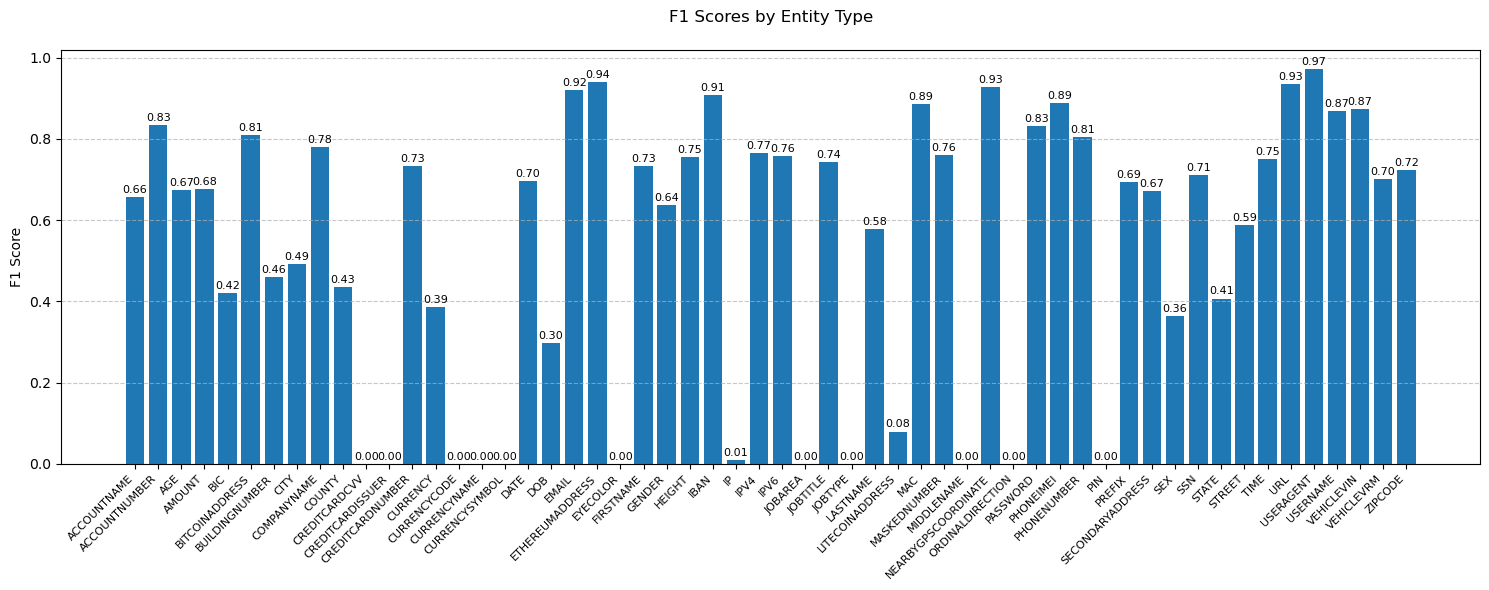

In [25]:
# Plot 1: Entity-wise F1 Scores
plt.figure(figsize=(15, 6))  # Wider figure for better readability
entity_types = list(validation_metrics['detailed'].keys())
f1_scores = [scores['f1'] for scores in validation_metrics['detailed'].values()]

plt.bar(entity_types, f1_scores)
plt.title('F1 Scores by Entity Type', fontsize=12, pad=20)
plt.ylabel('F1 Score', fontsize=10)

# Improve x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=8)  # ha='right' aligns rotated labels better
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Optional: Add value labels on top of each bar
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=8)

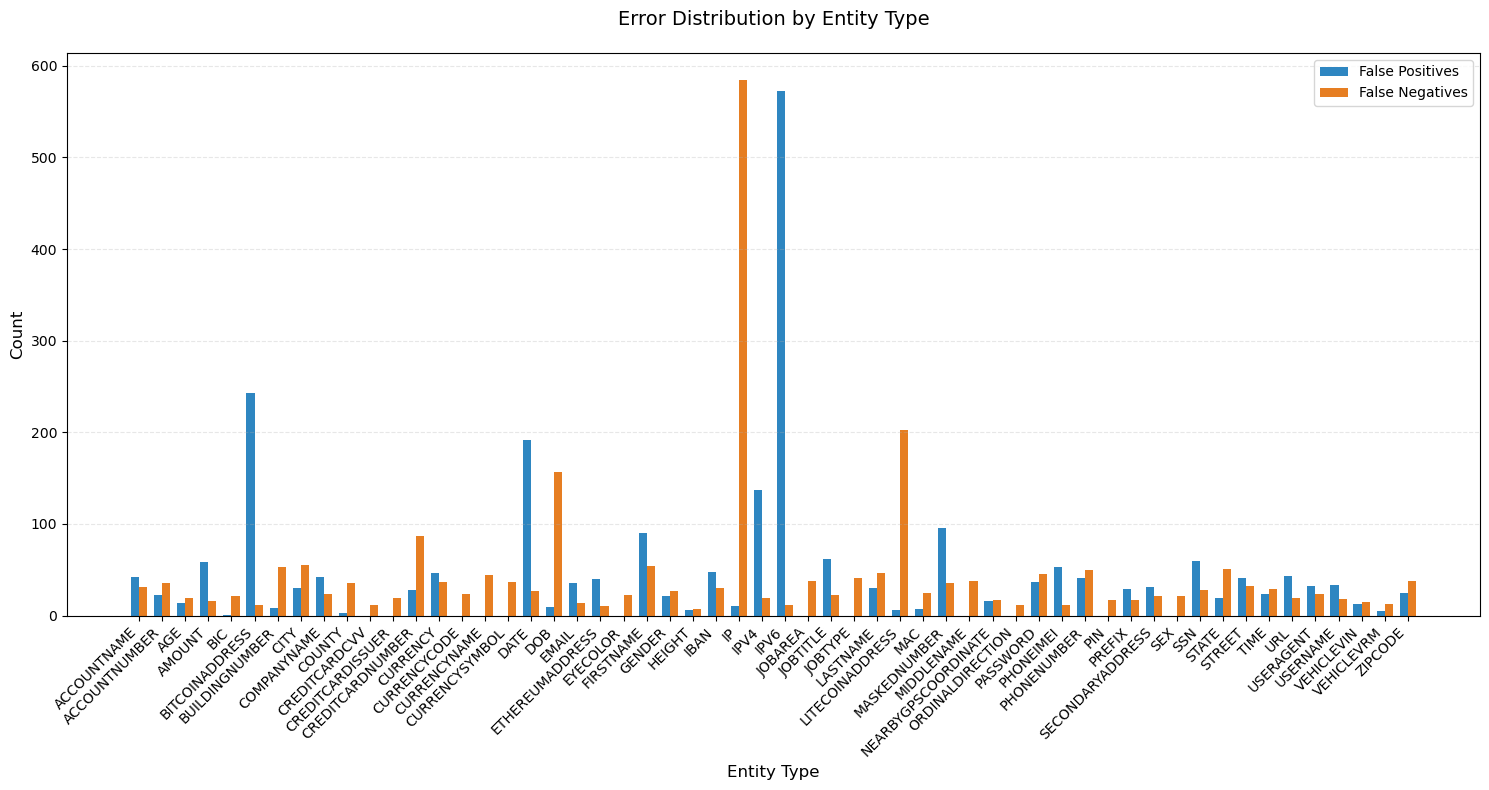

In [17]:
# Create a cleaner error distribution plot
plt.figure(figsize=(15, 8))  # Larger figure size

# Prepare data
entity_types = list(validation_metrics['detailed'].keys())
fp = [scores['false_positives'] for scores in validation_metrics['detailed'].values()]
fn = [scores['false_negatives'] for scores in validation_metrics['detailed'].values()]

# Create bar positions
x = np.arange(len(entity_types))
width = 0.35

# Create bars
plt.bar(x - width/2, fp, width, label='False Positives', color='#2E86C1')
plt.bar(x + width/2, fn, width, label='False Negatives', color='#E67E22')

# Customize plot
plt.title('Error Distribution by Entity Type', fontsize=14, pad=20)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Entity Type', fontsize=12)

# Improve x-axis labels
plt.xticks(x, entity_types, rotation=45, ha='right', fontsize=10)

# Add legend
plt.legend(fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [20]:
import time
import statistics
from tqdm import tqdm

def measure_inference_time(model, tokenizer, text, batch_size=1, num_runs=5):
    """Measure inference time for a given text and batch size"""
    # Create batch by repeating text
    texts = [text] * batch_size

    # Tokenize once outside the timing loop
    inputs = tokenizer(texts,
                      padding=True,
                      truncation=True,
                      return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Warm-up run
    with torch.no_grad():
        _ = model(**inputs)

    # Measure inference times
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.perf_counter()
            _ = model(**inputs)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end_time = time.perf_counter()
            times.append(end_time - start_time)

    return {
        'mean': statistics.mean(times),
        'std': statistics.stdev(times),
        'min': min(times),
        'max': max(times)
    }

# Test texts of different lengths
test_texts = [
    "Short text with name John Smith.",  # ~30 chars
    "Medium length text about Jane Doe who lives in New York and works at Apple Inc.",  # ~80 chars
    "Longer text about Michael Johnson who can be contacted at michael.j@email.com and lives at 123 Main Street, Los Angeles, CA 90001. His phone number is 555-0123.",  # ~150 chars
    "Very long text with multiple entities: Sarah Williams and Robert Brown are working on a project at Microsoft. They can be reached at sarah.w@company.com and robert.b@company.com respectively. Their office addresses are 456 Tech Boulevard, Seattle, WA 98101 and 789 Innovation Drive, San Francisco, CA 94105.",  # ~300 chars
]

# Test different batch sizes
batch_sizes = [1, 4, 8, 16, 32]

# Collect timing data
timing_data = []
model.eval()  # Ensure model is in evaluation mode

print("Measuring inference times...")
for text in tqdm(test_texts, desc="Processing different text lengths"):
    text_length = len(text)
    for batch_size in batch_sizes:
        timing_result = measure_inference_time(model, tokenizer, text, batch_size)
        timing_data.append({
            'text_length': text_length,
            'batch_size': batch_size,
            'timing': timing_result
        })

# Plot 1: Inference Time vs Text Length
plt.figure(figsize=(15, 10))
for batch_size in batch_sizes:
    batch_data = [d for d in timing_data if d['batch_size'] == batch_size]
    plt.plot([d['text_length'] for d in batch_data],
             [d['timing']['mean'] * 1000 for d in batch_data],
             marker='o',
             label=f'Batch size {batch_size}')

plt.title('Inference Time vs Text Length')
plt.xlabel('Text Length (characters)')
plt.ylabel('Average Inference Time (ms)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('inference_time_vs_length.png')
plt.close()

# Plot 2: Inference Time per Sample vs Batch Size
plt.figure(figsize=(15, 10))
text_lengths = sorted(set(d['text_length'] for d in timing_data))
for length in text_lengths:
    length_data = [d for d in timing_data if d['text_length'] == length]
    plt.plot([d['batch_size'] for d in length_data],
             [d['timing']['mean'] * 1000 / d['batch_size'] for d in length_data],
             marker='o',
             label=f'Text length {length}')

plt.title('Inference Time per Sample vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Average Time per Sample (ms)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('time_per_sample_vs_batch.png')
plt.close()

# Plot 3: Throughput vs Batch Size
plt.figure(figsize=(15, 10))
for length in text_lengths:
    length_data = [d for d in timing_data if d['text_length'] == length]
    plt.plot([d['batch_size'] for d in length_data],
             [d['batch_size'] / d['timing']['mean'] for d in length_data],
             marker='o',
             label=f'Text length {length}')

plt.title('Throughput vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Throughput (samples/second)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('throughput_vs_batch.png')
plt.close()

# Plot 4: Timing Variability
plt.figure(figsize=(15, 10))
variance_data = []
labels = []
for d in timing_data:
    variance_data.append(d['timing']['std'] * 1000)  # Convert to ms
    labels.append(f"L{d['text_length']}-B{d['batch_size']}")

plt.bar(range(len(variance_data)), variance_data)
plt.xticks(range(len(variance_data)), labels, rotation=90)
plt.title('Inference Time Variability')
plt.xlabel('Text Length - Batch Size')
plt.ylabel('Standard Deviation (ms)')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('timing_variability.png')
plt.close()

# Print summary statistics
print("\nPerformance Summary:")
print("-" * 50)
print(f"Device used: {device}")
print("\nAverage inference times (ms):")
for batch_size in batch_sizes:
    batch_data = [d for d in timing_data if d['batch_size'] == batch_size]
    avg_time = statistics.mean(d['timing']['mean'] for d in batch_data) * 1000
    print(f"Batch size {batch_size}: {avg_time:.2f} ms")

print("\nMaximum throughput:")
max_throughput = max(d['batch_size'] / d['timing']['mean'] for d in timing_data)
print(f"{max_throughput:.2f} samples/second")

print("\nOptimal batch size for throughput:")
throughput_by_batch = {
    batch_size: statistics.mean(
        [d['batch_size'] / d['timing']['mean']
         for d in timing_data if d['batch_size'] == batch_size]
    )
    for batch_size in batch_sizes
}
optimal_batch = max(throughput_by_batch.items(), key=lambda x: x[1])
print(f"Batch size {optimal_batch[0]}: {optimal_batch[1]:.2f} samples/second")

Measuring inference times...


Processing different text lengths: 100%|██████████| 4/4 [00:18<00:00,  4.55s/it]



Performance Summary:
--------------------------------------------------
Device used: cpu

Average inference times (ms):
Batch size 1: 34.46 ms
Batch size 4: 62.12 ms
Batch size 8: 104.40 ms
Batch size 16: 185.73 ms
Batch size 32: 374.25 ms

Maximum throughput:
315.96 samples/second

Optimal batch size for throughput:
Batch size 32: 147.99 samples/second
